# Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:
   - преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
   - обученные поверх аудиофич ML модели
  
1. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

1. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио. 
    - Покажите кластеризацию эмбеддингов по видам

1. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.



Датасеты:
1. [Датасет](https://www.kaggle.com/vinayshanbhag/bird-song-data-set) американских птиц
1. Почищенный от фонового шума BirdCall [датасет](https://www.kaggle.com/luisblanche/birdcall-singing-3)
1. [Датасет](https://www.kaggle.com/luisblanche/birdcall-singing-0) BirdCall часть 1

### imports and stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Data\ Analysis

/content/drive/MyDrive/Data Analysis


In [ ]:
! pip install librosa
! pip install soundfile

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=4fd8690f2fd12d9ca0df05a68319db111310b849289bb6d99683c7e007286544
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=d59f0387e7ad4a3bde73e4aa45f9b97f734e7463fbe9f0c011bbeb5b2c774a55
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
import librosa
import librosa, librosa.display, librosa.feature
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import umap
import torch

from tqdm.notebook import tqdm
from scipy import spatial
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### download data

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d vinayshanbhag/bird-song-data-set

100% 2.09G/2.09G [00:24<00:00, 62.6MB/s]
100% 2.09G/2.09G [00:24<00:00, 91.1MB/s]


In [ ]:
! mkdir birds
! unzip bird-song-data-set.zip -d data/birds
! rm -rf bird-song-data-set.zip

## preprocess data

In [ ]:
IPython.display.Audio('data/birds/wavfiles/11713-0.wav')

In [ ]:
df = pd.read_csv("data/birds/bird_songs_metadata.csv", index_col="filename")
df.head(1)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks
filename,,,,,,,,,,,,,,,,,
557838-0.wav,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor..."


In [ ]:
df['species'].value_counts()

melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: species, dtype: int64

In [ ]:
df['species'] = df['species'].astype('category').cat.codes
df = df[['species']]
df.head(5)

,species
filename,
557838-0.wav,0
557838-1.wav,0
557838-4.wav,0
557838-5.wav,0
557838-6.wav,0


## create embeddings

In [ ]:
FRAME_SIZE = 2048
HOP_LENGTH = 512

In [ ]:
def extract_features(signal, sr):
    # spectral centroid
    # weighted mean of the frequencies in signal
    sc = librosa.feature.spectral_centroid(y=signal, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    mean_sc = np.mean(sc)
    max_sc = np.max(sc)

    # bandwidth
    # the weighted mean of the distances of frequency bands from the SC
    bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    mean_bw = bw.mean()
    num_windows = 10
    window_i = np.linspace(0,len(bw)-1,num_windows,dtype=int)
    window_bw = bw[window_i]

    # zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    mean_zcr = np.mean(zcr)
    max_zcr = np.max(zcr)

    # root mean square
    # amplitude less sensitive to outliers
    rms = librosa.feature.rms(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    mean_rms = np.mean(rms)
    max_rms = np.max(rms)

    return np.hstack((max_sc,mean_zcr,mean_rms,window_bw))

In [ ]:
def extract_features_2(signal, sr):
    mels = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                          n_fft=FRAME_SIZE, 
                                          hop_length=HOP_LENGTH)
    # print(mels.shape, mels.dtype)
    mels = mels.mean(axis=1)
    return mels

In [ ]:
X = []
Y = []
for filename in tqdm(df.index):
    audio_file = f"data/birds/wavfiles/{filename}"
    signal, sr = librosa.load(audio_file) 
    X.append(extract_features(signal, sr))
    Y.append(df.loc[filename]['species'])
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

  0%|          | 0/5422 [00:00<?, ?it/s]

(5422, 13) (5422,)


In [ ]:
X2 = []
Y2 = []
for filename in tqdm(df.index):
    audio_file = f"data/birds/wavfiles/{filename}"
    signal, sr = librosa.load(audio_file) 
    X2.append(extract_features_2(signal, sr))
    Y2.append(df.loc[filename]['species'])
X2 = np.array(X2)
Y2 = np.array(Y2)
print(X.shape, Y.shape)

  0%|          | 0/5422 [00:00<?, ?it/s]

(5422, 13) (5422,)


## visualize embeddings

In [ ]:
embs_tsne_1 = TSNE(n_components=2, random_state=0).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


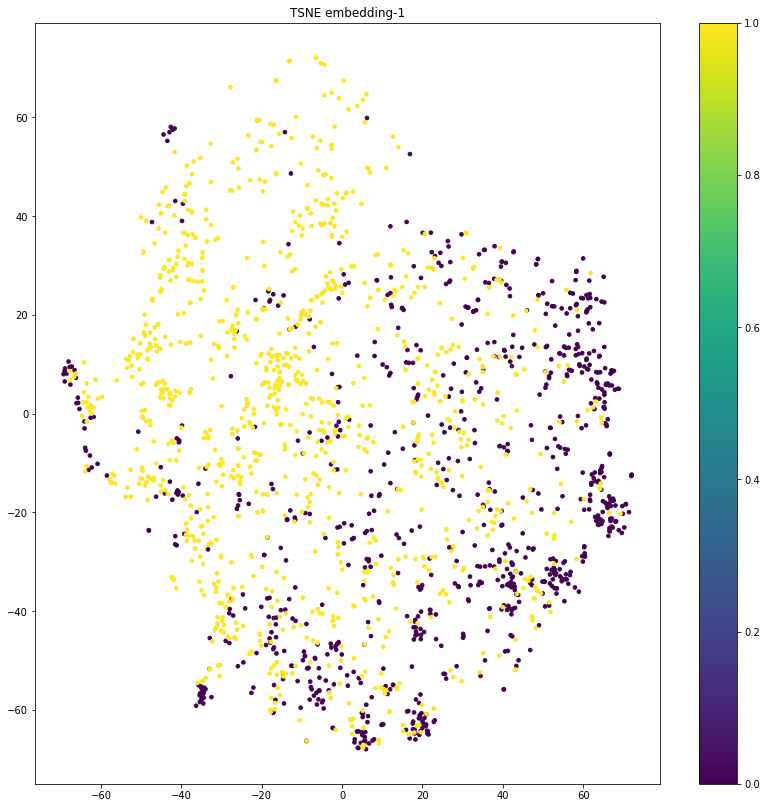

In [ ]:
emb_subset = embs_tsne_1[Y<=1]
y_subset = Y[Y<=1]

plt.figure(figsize=(14,14))
plt.title('TSNE embedding-1')
plt.scatter(emb_subset[:, 0], emb_subset[:, 1], c=y_subset, s=13)
plt.colorbar()
plt.show()

In [ ]:
X_normilized = StandardScaler().fit_transform(X)

embs_umap_1 = umap.UMAP(random_state=0, 
                        n_neighbors=100, 
                        min_dist = 0.05
                        ).fit_transform(X_normilized)

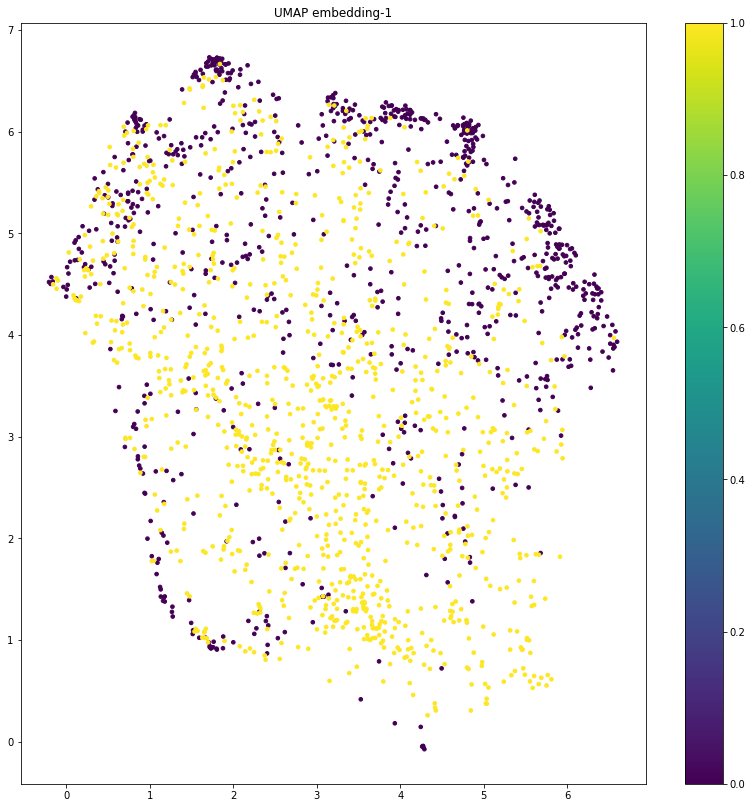

In [ ]:
emb_subset = embs_umap_1[Y<=1]
y_subset = Y[Y<=1]

plt.figure(figsize=(14,14))
plt.title('UMAP embedding-1')
plt.scatter(emb_subset[:, 0], emb_subset[:, 1], c=y_subset, s=13)
plt.colorbar()
plt.show()

In [ ]:
embs_tsne_2 = TSNE(n_components=2, random_state=0).fit_transform(X2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


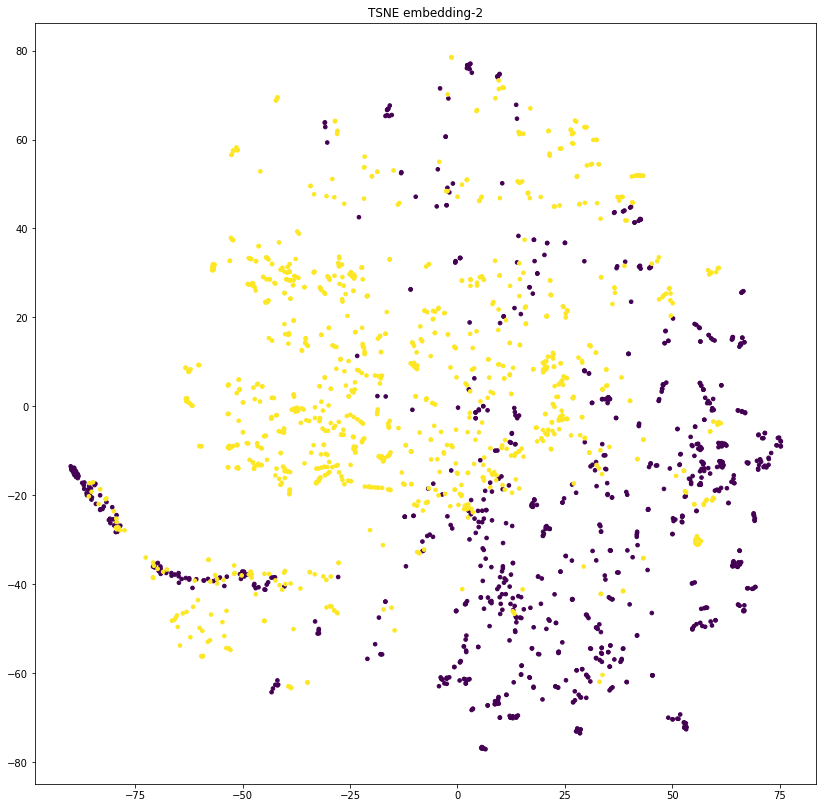

In [ ]:
emb_subset = embs_tsne_2[Y<=1]
y_subset = Y[Y<=1]

plt.figure(figsize=(14,14))
plt.title('TSNE embedding-2')
plt.scatter(emb_subset[:, 0], emb_subset[:, 1], c=y_subset, s=13)
plt.show()

In [ ]:
embs_umap_2 = umap.UMAP(random_state=0).fit_transform(X2)

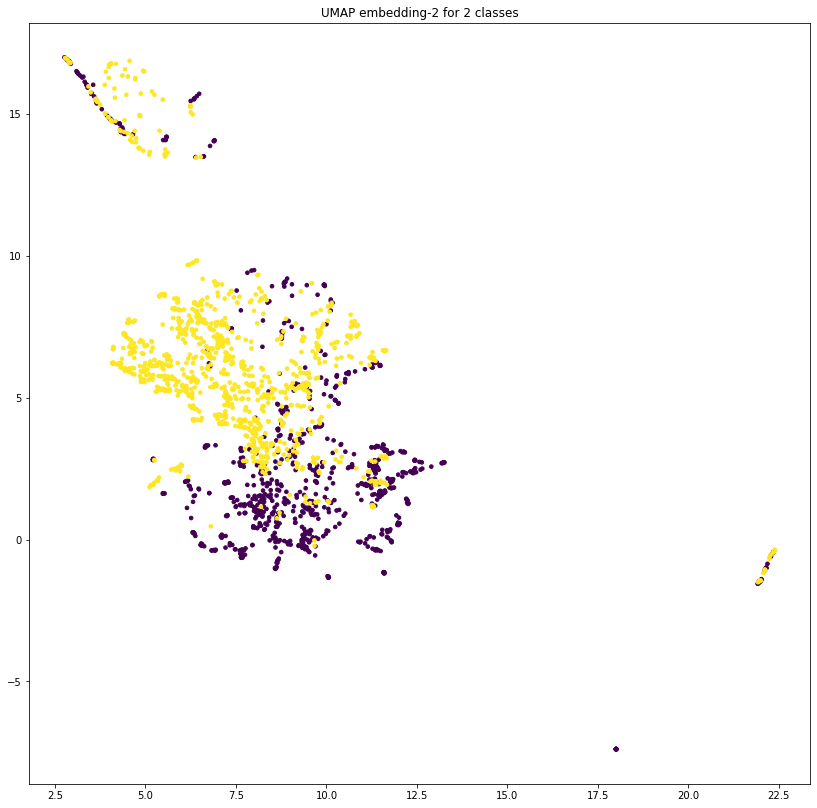

In [ ]:
emb_subset = embs_umap_2[Y<=1]
y_subset = Y[Y<=1]

plt.figure(figsize=(14,14))
plt.title('UMAP embedding-2 for 2 classes')
plt.scatter(emb_subset[:, 0], emb_subset[:, 1], c=y_subset, s=13)
plt.show()

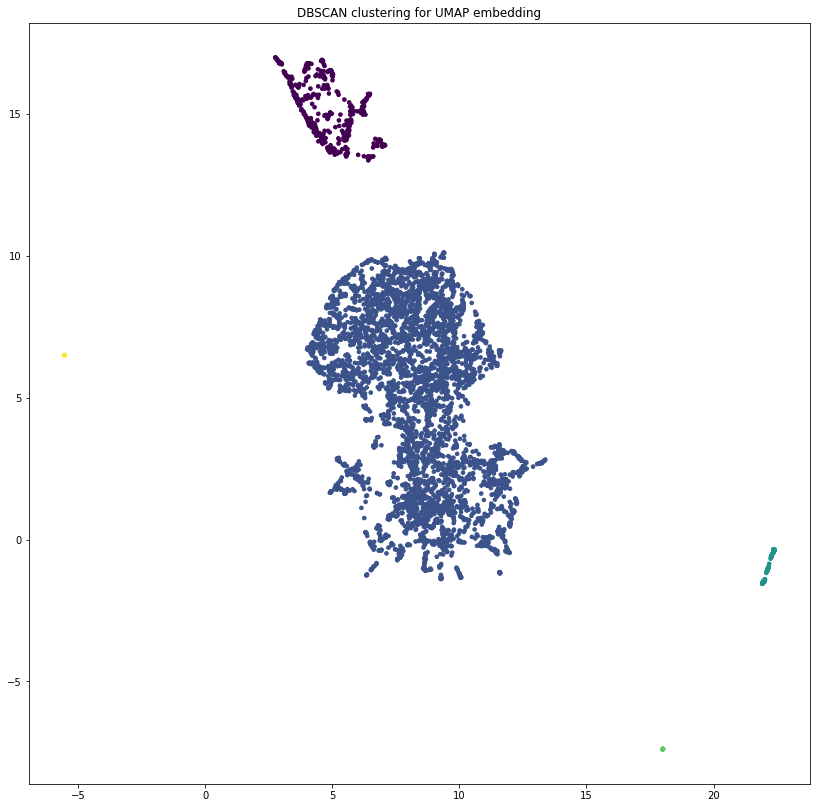

In [ ]:
X_normilized = StandardScaler().fit_transform(embs_umap_2)

db = DBSCAN().fit(X_normilized)

plt.figure(figsize=(14, 14))
plt.scatter(embs_umap_2[:, 0], embs_umap_2[:, 1], c=db.labels_, s=13)
plt.title("DBSCAN clustering for UMAP embedding")
plt.show()

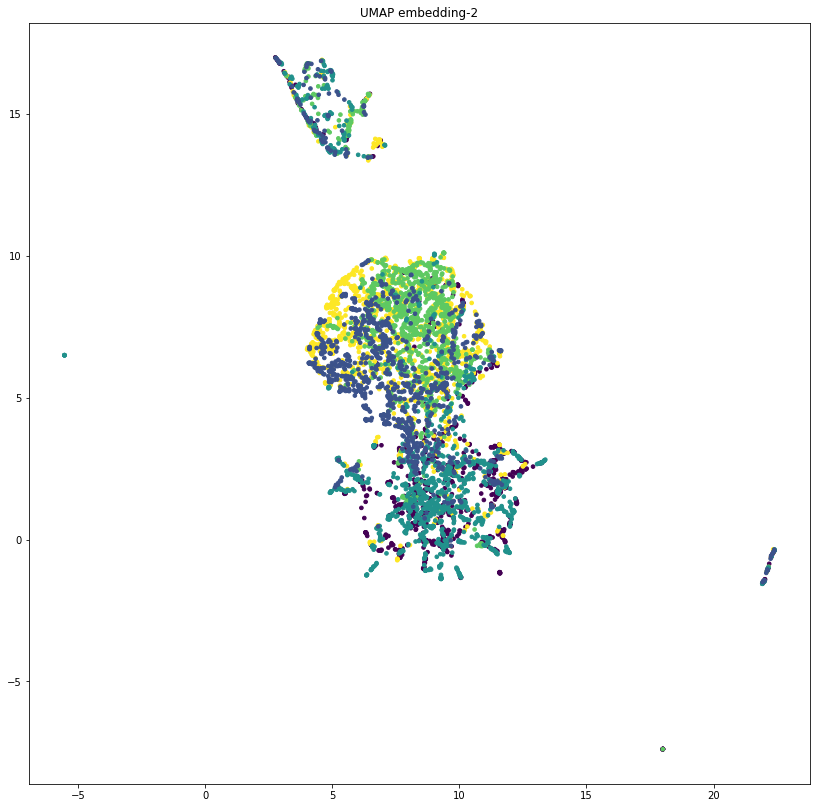

In [ ]:
plt.figure(figsize=(14,14))
plt.title('UMAP embedding-2')
plt.scatter(embs_umap_2[:, 0], embs_umap_2[:, 1], c=Y, s=13)
plt.show()

## compare close embeddings

In [ ]:
def get_nearest():
    random_index = np.random.randint(0, len(embs_umap_2))
    random_point = embs_umap_2[random_index]

    distances, nearest_indecies = spatial.KDTree(embs_umap_2).query(random_point, k=2)
    nearest_index = nearest_indecies[1]

    return random_index, nearest_index

In [ ]:
random_index, nearest_index = get_nearest()

In [ ]:
print(df.iloc[[random_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[random_index]].index.values[0]}")

               species
filename              
483578-16.wav        3


In [ ]:
print(df.iloc[[nearest_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[nearest_index]].index.values[0]}")

              species
filename             
338199-1.wav        3


In [ ]:
print(df.iloc[[random_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[random_index]].index.values[0]}")

              species
filename             
220402-9.wav        1


In [ ]:
print(df.iloc[[nearest_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[nearest_index]].index.values[0]}")

               species
filename              
140466-15.wav        1


In [ ]:
print(df.iloc[[random_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[random_index]].index.values[0]}")

             species
filename            
18484-0.wav        4


In [ ]:
print(df.iloc[[nearest_index]])
IPython.display.Audio(f"data/birds/wavfiles/{df.iloc[[nearest_index]].index.values[0]}")

              species
filename             
559014-6.wav        4
